In [1]:
import os
from time import sleep

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementNotInteractableException
from selenium.common.exceptions import StaleElementReferenceException
from bs4 import BeautifulSoup

##############################################################  ############
##################### variable related selenium ##########################
##########################################################################

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())
review_list = []

def main():
    global driver, load_wb, review_num, n

    driver.implicitly_wait(4)  # 렌더링 될때까지 기다린다 4초
    driver.get('https://map.kakao.com/')  # 주소 가져오기

    # 검색할 목록
    place_infos = ['강남구 음식점']
    n = 1
    
    for i, place in enumerate(place_infos):
        # delay
        if i % 4 == 0 and i != 0:
            sleep(5)
        search(place)

    driver.quit()
    print("finish")


def search(place):
    global driver

    search_area = driver.find_element_by_xpath('//*[@id="search.keyword.query"]')  # 검색 창
    search_area.send_keys(place)  # 검색어 입력
    driver.find_element_by_xpath('//*[@id="search.keyword.submit"]').send_keys(Keys.ENTER)  # Enter로 검색
    sleep(1)

    # 검색된 정보가 있는 경우에만 탐색
    # 1번 페이지 place list 읽기
    html = driver.page_source

    soup = BeautifulSoup(html, 'html.parser')
    place_lists = soup.select('.placelist > .PlaceItem') # 검색된 장소 목록

    # 검색된 첫 페이지 장소 목록 크롤링하기
    crawling(place, place_lists)
    search_area.clear()

    # 더보기 클릭해서 2페이지
    try:
        driver.find_element_by_xpath('//*[@id="info.search.place.more"]').send_keys(Keys.ENTER)
        sleep(1)

        # 2~ 5페이지 읽기
        for i in range(2, 6):
            # 페이지 넘기기
            xPath = '//*[@id="info.search.page.no' + str(i) + '"]'
            driver.find_element_by_xpath(xPath).send_keys(Keys.ENTER)
            sleep(1)

            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            place_lists = soup.select('.placelist > .PlaceItem') # 장소 목록 list

            crawling(place, place_lists)

    except ElementNotInteractableException:
        print('not found')
    finally:
        search_area.clear()


def crawling(place, place_lists):
    global n
    """
    페이지 목록을 받아서 크롤링 하는 함수
    :param place: 리뷰 정보 찾을 장소이름
    """
    
    while_flag = False
    for i, place in enumerate(place_lists):
        # 광고에 따라서 index 조정해야함
        if i >= 3:
            i += 1

        place_name = place.select('.head_item > .tit_name > .link_name')[0].text  # place name
        place_address = place.select('.info_item > .addr > p')[0].text  # place address

        detail_page_xpath = '//*[@id="info.search.place.list"]/li[' + str(i + 1) + ']/div[5]/div[4]/a[1]'
        driver.find_element_by_xpath(detail_page_xpath).send_keys(Keys.ENTER)
        driver.switch_to.window(driver.window_handles[-1])  # 상세정보 탭으로 변환
        sleep(1)

        # 첫 페이지
        extract_review(place_name)
        
        # 2-5 페이지
        idx = 3
        try:
            page_num = len(driver.find_elements_by_class_name('link_page')) # 페이지 수 찾기
            for i in range(page_num-1):
                # css selector를 이용해 페이지 버튼 누르기
                driver.find_element_by_css_selector('#mArticle > div.cont_evaluation > div.evaluation_review > div > a:nth-child(' + str(idx) +')').send_keys(Keys.ENTER)
                sleep(1)
                extract_review(place_name)
                idx += 1
            driver.find_element_by_link_text('다음').send_keys(Keys.ENTER) # 5페이지가 넘는 경우 다음 버튼 누르기
            sleep(1)
            extract_review(place_name) # 리뷰 추출
        except (NoSuchElementException, ElementNotInteractableException):
            print("no review in crawling")

        # 그 이후 페이지
        while True:
            idx = 4
            try:
                page_num = len(driver.find_elements_by_class_name('link_page'))
                for i in range(page_num-1):
                    driver.find_element_by_css_selector('#mArticle > div.cont_evaluation > div.evaluation_review > div > a:nth-child(' + str(idx) +')').send_keys(Keys.ENTER)
                    sleep(1)
                    extract_review(place_name)
                    idx += 1
                driver.find_element_by_link_text('다음').send_keys(Keys.ENTER) # 10페이지 이상으로 넘어가기 위한 다음 버튼 클릭
                sleep(1)
                extract_review(place_name) # 리뷰 추출
            except (NoSuchElementException, ElementNotInteractableException):
                print("no review in crawling")
                break

        driver.close()
        driver.switch_to.window(driver.window_handles[0])  # 검색 탭으로 전환
        n += 1


def extract_review(place_name):
    global driver, n
    
    ret = True

    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    # 첫 페이지 리뷰 목록 찾기
    review_lists = soup.select('.list_evaluation > li')

    # 리뷰가 있는 경우
    if len(review_lists) != 0:
        for i, review in enumerate(review_lists):
            comment = review.select('.txt_comment > span') # 리뷰
            rating = review.select('.grade_star > em') # 별점
            val = ''
            
            if len(comment[0].text) != 0:
                if len(rating) != 0:
                    if rating[0].text.replace('점', '') != '3':
                        val = [n, place_name, comment[0].text, int(rating[0].text.replace('점', '')), len(comment[0].text)]
                else:
                    val = [n, place_name, comment[0].text + '/0']
                review_list.append(val)

    else:
        print('no review in extract')
        ret = False
        
    return ret
    

if __name__ == "__main__":
    main()



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [C:\Users\sjhye\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache
<ipython-input-1-28f10267fdc1>:18: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-1-28f10267fdc1>:44: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_area = driver.find_element_by_xpath('//*[@id="search.keyword.query"]')  # 검색 창
<ipython-input-1-28f10267fdc1>:46: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_xpath('//*[@id="search.keyword.submit"]').send_keys(Keys.ENTER)  # Enter로 검색
<ipython-input-1-28f10267fdc1>:101: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element(

no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling


<ipython-input-1-28f10267fdc1>:62: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_xpath('//*[@id="info.search.place.more"]').send_keys(Keys.ENTER)
<ipython-input-1-28f10267fdc1>:69: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_xpath(xPath).send_keys(Keys.ENTER)


no review in crawling
no review in crawling
no review in extract
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in extract
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in crawling
no review in

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm 
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
len(review_list)
review_list

[[1, '중앙해장', '곱창전골 맛있음 ㅋ 조미료맛 안나고 담백함', 4, 23],
 [1, '중앙해장', '맛있어요', 4, 4],
 [1, '중앙해장', '친절하시고 사장님이 위트있으셔서 좋았어요! 무엇보다 해장국 양이 정말 많았습니다', 5, 44],
 [1, '중앙해장', '한우라는 메리트를 빼면 그다지..?', 2, 19],
 [1,
  '중앙해장',
  '곱창전골 찐 맛집 이제까지 먹은 곱창전골 중에서 제일 맛있었어요 채소도 신선해서 건강하게 얼큰구수한 맛',
  5,
  57],
 [1, '중앙해장', '다먹고 물 벌컥벌컥 마시게 되지 않는 건강한 곱창전골  ', 5, 31],
 [1,
  '중앙해장',
  '그냥 쏘쏘한듯 선지가 너무 흐믈흐믈해요  국물은 맛있긴합니다  11.26 재방문해서 내장탕은 어떨까 먹어봤는데.., 더맛없음   tip: 곱창전골만 드세요 ★★★★★:JMT 멀어도 꼭 가야할 맛집(재방문 O) ★★★★:소개해줄정도로 괜찮은 맛집(재방문 O) ★★★:흔한 집(재방문 X) ★★:가서 입맛 버리고 오는곳(") ★:우리집 누렁이도 거르는 곳(") ',
  2,
  200],
 [1,
  '중앙해장',
  '가야는이유 : 강남에서 맛보는 마장동 안가는이유 : 한그릇만 먹고프지만 줄이 있으면  양지곰탕 : 한우가 정말 맞나 싶을만큼 고기가 나오는, 깊은맛보다는 깔끔하고 소금을 추가하지 않아도될만큼 간이 딱 맞는',
  4,
  114],
 [1, '중앙해장', '굿', 5, 1],
 [1, '중앙해장', '내장탕은 못먹어서 방문할 때마다 양지곰탕으로 고르는데요, 맑고 푸짐하고 늘 만족해요', 5, 46],
 [1, '중앙해장', '굿', 5, 1],
 [1, '중앙해장', '유일하게 아쉬웠던 점은 이 곳을 이제야 알았다는 것.', 4, 29],
 [1, '중앙해장', '선지 추가 해주시는 거 넘 좋아요', 5, 18],
 [1, '중앙해장', '곱창전골 양 푸짐하고 육수가 진짜 맛있어요. 야채추가하고 마지막에 칼국수면까지 완벽해요.',

In [4]:
total_data = pd.DataFrame(review_list)

total_data.columns = ['#', 'name', 'text', 'stars', 'text_length']
total_data['label'] = np.select([total_data.stars > 3], [1], default=0)
# 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여. 
# 부여된 레이블은 새로 생성한 label이라는 열에 저장

In [5]:
total_data

,#,name,text,stars,text_length,label
0,1.0,중앙해장,곱창전골 맛있음 ㅋ 조미료맛 안나고 담백함,4.0,23.0,1
1,1.0,중앙해장,맛있어요,4.0,4.0,1
2,1.0,중앙해장,친절하시고 사장님이 위트있으셔서 좋았어요! 무엇보다 해장국 양이 정말 많았습니다,5.0,44.0,1
3,1.0,중앙해장,한우라는 메리트를 빼면 그다지..?,2.0,19.0,0
4,1.0,중앙해장,곱창전골 찐 맛집 이제까지 먹은 곱창전골 중에서 제일 맛있었어요 채소도 신선해서 건...,5.0,57.0,1
...,...,...,...,...,...,...
6126,75.0,최가네 버섯샤브매운탕칼국수,볶음밥 먹으러가는곳,5.0,10.0,1
6127,NaN,None,None,NaN,NaN,0
6128,75.0,최가네 버섯샤브매운탕칼국수,와 볶음밥 진짜 최고,5.0,11.0,1
6129,NaN,None,None,NaN,NaN,0


In [6]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   #            5260 non-null   float64
 1   name         5260 non-null   object 
 2   text         5260 non-null   object 
 3   stars        5260 non-null   float64
 4   text_length  5260 non-null   float64
 5   label        6131 non-null   int32  
dtypes: float64(3), int32(1), object(2)
memory usage: 263.6+ KB


In [7]:
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트
total_data['text'].nunique(), total_data['stars'].nunique()

(5108, 4)

<AxesSubplot:>

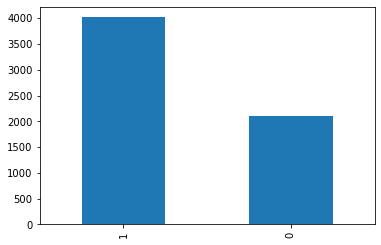

In [8]:
#train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포
total_data['label'].value_counts().plot(kind = 'bar') 

In [9]:
total_data.drop_duplicates(subset=['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
total_data = total_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(total_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [10]:
total_data['text'] = total_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
total_data[:20]

<ipython-input-10-d9860cb290e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['text'] = total_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거


,#,name,text,stars,text_length,label
0,1.0,중앙해장,곱창전골 맛있음 ㅋ 조미료맛 안나고 담백함,4.0,23.0,1
1,1.0,중앙해장,맛있어요,4.0,4.0,1
2,1.0,중앙해장,친절하시고 사장님이 위트있으셔서 좋았어요 무엇보다 해장국 양이 정말 많았습니다,5.0,44.0,1
3,1.0,중앙해장,한우라는 메리트를 빼면 그다지,2.0,19.0,0
4,1.0,중앙해장,곱창전골 찐 맛집 이제까지 먹은 곱창전골 중에서 제일 맛있었어요 채소도 신선해서 건...,5.0,57.0,1
5,1.0,중앙해장,다먹고 물 벌컥벌컥 마시게 되지 않는 건강한 곱창전골,5.0,31.0,1
6,1.0,중앙해장,그냥 쏘쏘한듯 선지가 너무 흐믈흐믈해요 국물은 맛있긴합니다 재방문해서 내장탕은...,2.0,200.0,0
7,1.0,중앙해장,가야는이유 강남에서 맛보는 마장동 안가는이유 한그릇만 먹고프지만 줄이 있으면 ...,4.0,114.0,1
8,1.0,중앙해장,굿,5.0,1.0,1
9,1.0,중앙해장,내장탕은 못먹어서 방문할 때마다 양지곰탕으로 고르는데요 맑고 푸짐하고 늘 만족해요,5.0,46.0,1


In [11]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5108 entries, 0 to 6130
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   #            5108 non-null   float64
 1   name         5108 non-null   object 
 2   text         5108 non-null   object 
 3   stars        5108 non-null   float64
 4   text_length  5108 non-null   float64
 5   label        5108 non-null   int32  
dtypes: float64(3), int32(1), object(2)
memory usage: 259.4+ KB


In [12]:
total_data['text'] = total_data['text'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
total_data['text'].replace('', np.nan, inplace=True)
print(total_data.isnull().sum())

#               0
name            0
text           73
stars           0
text_length     0
label           0
dtype: int64


<ipython-input-12-e284ed6aebab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['text'] = total_data['text'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
C:\Users\sjhye\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [13]:
total_data = total_data.dropna(how = 'any')
print(len(total_data))

5035


In [14]:
total_data['text'] = total_data['text'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
total_data['text'].replace('', np.nan, inplace=True)
print(total_data.isnull().sum())

#              0
name           0
text           0
stars          0
text_length    0
label          0
dtype: int64


In [39]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 3776
테스트용 리뷰의 개수 : 1259


In [40]:
stopwords100 = []
stopwords = []

f = open("kor_stopwords100.txt", 'r', encoding="utf-8")
stopwords100 = f.readlines()
for stopword in stopwords100:
    stopwords.append(stopword.rstrip()[0])
    
print(stopwords)

f.close()

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사', '주', '아', '등', '같', '우', '때', '년', '가', '한', '지', '대', '오', '말', '일', '그', '위', '때', '그', '두', '말', '알', '그', '받', '못', '일', '그', '또', '문', '더', '사', '많', '그', '좋', '크', '따', '중', '나', '가', '씨', '시', '만', '지', '생', '그', '속', '하', '집', '살', '모', '적', '월', '데', '자', '안', '어', '내', '내', '경', '명', '생', '시', '그', '다', '이', '앞', '보', '번', '나', '다', '어', '여', '개', '전', '들', '사', '이', '점', '싶', '말', '정', '좀', '원', '잘', '통', '소', '놓']


In [41]:
okt = Okt()

X_train = []
for sentence in tqdm(train_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 3776/3776 [00:23<00:00, 161.81it/s]


In [42]:
print(X_train[:3])

[['수인', '가능성', '측정기', '평냉', '처음', '먹다', '검증', '대상', '을', '불다', '싱겁다', '연신', '불평', '하다', '바로', '차단', '슬램덩크', '로', '치면', '정우성', '일반', '음식점', '별개', '만점', '무시', '하늘', '은', '을지', '면옥', '을', '낳다', '왜', '진미', '를', '낳다', '생각', '하다', '볼', '삼', '국연', '의', '주유', '대사', '오마쥬', '비고', '차요', '의', '불친절', '은', '웨이팅', '을', '줄이다', '추진', '력', '을', '얻다', '포석'], ['고기', '를', '자다', '모르다', '사람', '한테', '맛집', '이라니', '도', '되다', '제', '껍살', '을', '먹다', '모르다', '삼겹살', '과', '목살', '은', '최고', '이다', '경쟁', '업체', '악플', '을', '달다', '아니다', '의심', '되다', '정도', '이다', '제', '사람', '많이', '없다', '가다', '한창', '피크', '타임', '서비스', '는', '어떻다', '모르다', '적어도', '제', '몇', '갈다', '만큼은', '괜찮다', '물론', '가격', '비싸다', '은', '맞다', '그러나', '이렇게'], ['음식', '너무', '맛있다', '다기', '보다', '친절하다', '아늑하다', '뭔가', '젊다', '여자', '좋아하다', '그렇다', '분위기', '가볍다', '먹기', '좋다']]


In [43]:
X_test = []
for sentence in tqdm(test_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 1259/1259 [00:07<00:00, 167.87it/s]


In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'맛있다': 1, '하다': 2, '도': 3, '먹다': 4, '에': 5, '맛': 6, '은': 7, '좋다': 8, '너무': 9, '는': 10, '있다': 11, '없다': 12, '을': 13, '가다': 14, '보다': 15, '이다': 16, '않다': 17, '같다': 18, '직원': 19, '많다': 20, '진짜': 21, '음식': 22, '에서': 23, '으로': 24, '곳': 25, '가격': 26, '로': 27, '의': 28, '오다': 29, '를': 30, '아니다': 31, '나오다': 32, '친절하다': 33, '분': 34, '요': 35, '분위기': 36, '사람': 37, '고': 38, '되다': 39, '고기': 40, '맛집': 41, '들다': 42, '파스타': 43, '하고': 44, '정말': 45, '그냥': 46, '서비스': 47, '정도': 48, '별로': 49, '시키다': 50, '방문': 51, '최고': 52, '괜찮다': 53, '과': 54, '여기': 55, '그렇다': 56, '비싸다': 57, '많이': 58, '팅': 59, '생각': 60, '밥': 61, '양': 62, '기다리다': 63, '자다': 64, '면': 65, '다른': 66, '웨이': 67, '커피': 68, '인': 69, '메뉴': 70, '시간': 71, '주문': 72, '인데': 73, 'ㅠㅠ': 74, '엄청': 75, '싶다': 76, '랑': 77, '테이블': 78, '주다': 79, '분들': 80, '받다': 81, '추천': 82, '느낌': 83, '거': 84, '하나': 85, '넘다': 86, '까지': 87, 'ㅎㅎ': 88, '모르다': 89, '케이크': 90, '갈다': 91, '손님': 92, '서': 93, '존맛': 94, '와': 95, '제': 96, '좋아하다': 97, '이랑': 98, '스테이크': 99, '나다': 100, '웨이팅': 101

In [45]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6393
등장 빈도가 1번 이하인 희귀 단어의 수: 2970
단어 집합에서 희귀 단어의 비율: 46.45706241201314
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.528129288001219


In [46]:
# 전체 단어 개수 중 빈도수 1이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3424


In [47]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [48]:
print(X_train[:3])

[[1, 1, 1, 699, 121, 5, 1, 2529, 14, 451, 1321, 1, 1, 3, 206, 1, 1, 28, 2043, 1, 919, 535, 1477, 2530, 1206, 2531, 8, 2044, 1322, 14, 2045, 105, 1478, 31, 2045, 61, 3, 536, 1725, 1, 29, 1, 1, 1, 2532, 2533, 29, 186, 8, 102, 14, 608, 1, 1, 14, 2046, 1], [41, 31, 65, 90, 38, 344, 42, 1479, 4, 40, 97, 2047, 14, 5, 90, 639, 55, 555, 8, 53, 17, 1726, 2534, 1, 14, 345, 32, 1727, 40, 49, 17, 97, 38, 59, 13, 15, 1, 2048, 861, 48, 11, 452, 90, 2049, 97, 333, 92, 2535, 54, 609, 27, 58, 8, 219, 862, 165], [23, 10, 2, 1, 16, 34, 2050, 752, 1323, 365, 98, 57, 37, 1480, 196, 9]]


리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 17.370233050847457


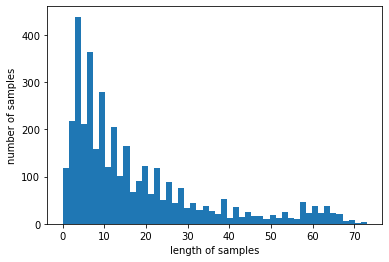

In [49]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

3775
3775


C:\Users\sjhye\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [51]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [52]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 88.74172185430463


In [53]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [54]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
47/48 [============================>.] - ETA: 0s - loss: 0.4958 - acc: 0.7749
Epoch 00001: val_acc improved from -inf to 0.81192, saving model to best_model.h5
48/48 [==============================] - 6s 82ms/step - loss: 0.4943 - acc: 0.7758 - val_loss: 0.6242 - val_acc: 0.8119
Epoch 2/15
47/48 [============================>.] - ETA: 0s - loss: 0.2921 - acc: 0.8846
Epoch 00002: val_acc improved from 0.81192 to 0.83576, saving model to best_model.h5
48/48 [==============================] - 3s 68ms/step - loss: 0.2926 - acc: 0.8841 - val_loss: 0.3452 - val_acc: 0.8358
Epoch 3/15
47/48 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9259
Epoch 00003: val_acc improved from 0.83576 to 0.90199, saving model to best_model.h5
48/48 [==============================] - 4s 75ms/step - loss: 0.1981 - acc: 0.9258 - val_loss: 0.2814 - val_acc: 0.9020
Epoch 4/15
47/48 [============================>.] - ETA: 0s - loss: 0.1502 - acc: 0.9475
Epoch 00004: val_acc did not imp

In [56]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

40/40 [==============================] - 1s 14ms/step - loss: 0.2825 - acc: 0.8912

 테스트 정확도: 0.8912


In [57]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [58]:
sentiment_predict('미슐랭 갔는데 맛없는 거 처음이어서 놀람. 냉면도 그냥저냥 넘 달고 별론데 튀김이 그렇게 맛이 없을수가 있을까; 맛이 세월때문에 저하된건지 모르겠지만 2021년 미슐랭 패는 정말 이해가 안감 튀김옷이 일본스타일도 아니고 두꺼운거고... 한국 분식집보다 맛이없는 새우튀김 만들기가 쉽지 않은데 가지튀김도 그냥 기름에만 튀겨도 맛있는데...')

91.59% 확률로 부정 리뷰입니다.


In [59]:
sentiment_predict('더운 여름 날 입맛없을때 특식으로 생각날것 같아요^^ 매장이 좀 덜 추웠다면 냉소바가 더 시원하게 느껴졌을것 같습니다!')

68.85% 확률로 긍정 리뷰입니다.
